In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
MERGED_DATASET_FILEPATH = Path("../data/WIG20.csv")

We will omit NaN values, because we want to investigate the possibility of optimization instead of full analysis.

In [3]:
df = pd.read_csv(MERGED_DATASET_FILEPATH, parse_dates=["Date"], index_col="Date")
df.head()

,PGN,SPL,GTC,CPS,PXM,PEO,BIO,OPL,MBK,ACP,PBG,CEZ,LTS,GTN,PKO,AGO,KGH,PKN
Date,,,,,,,,,,,,,,,,,,
2008-05-07,0.002412,0.044528,0.040209,0.004889,0.025710,0.026825,0.029851,0.004516,0.037730,0.008777,0.027439,0.008851,0.016224,0.011982,0.028052,-0.007332,0.029334,0.000233
2008-05-08,-0.009557,-0.005629,0.001312,-0.004006,0.009734,-0.037460,-0.014493,-0.008568,-0.028561,-0.016642,-0.025154,-0.012147,-0.022903,-0.007877,-0.014020,-0.022126,0.003690,-0.000732
2008-05-09,-0.007186,0.017058,-0.014157,-0.023465,-0.020666,0.010213,-0.014706,0.005904,-0.002676,0.005871,0.000000,-0.000582,-0.024020,0.019825,0.003180,-0.008766,-0.034807,0.003097
2008-05-12,0.024230,0.006308,0.028688,0.000785,0.005599,0.011840,0.000000,0.017523,0.004548,0.008769,0.025803,-0.004772,0.018189,0.019439,0.002957,0.008844,0.012318,0.001859
2008-05-13,0.000000,0.004941,0.050797,0.011564,-0.015387,0.017642,-0.014925,-0.006939,0.000814,-0.014478,-0.012254,-0.023708,0.002990,0.003842,0.008024,0.002495,0.011288,0.001690


In [4]:
df = df.dropna(axis=0)

## Plot of daily returns

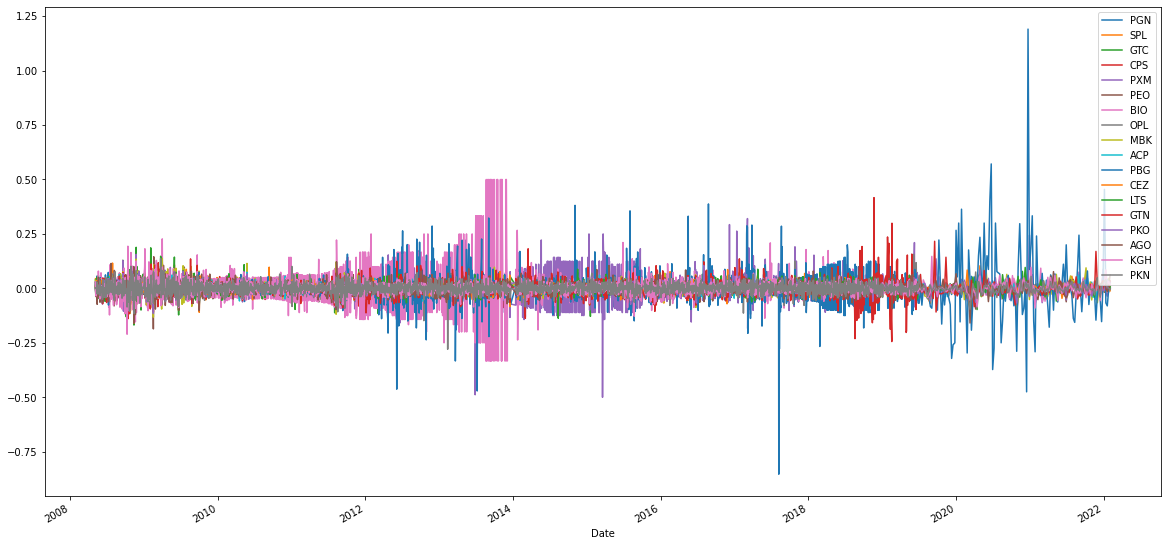

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(ax=ax)
plt.show()

## Mean and standard deviation of daily returns

In [7]:
mean_var_df = df.agg(["mean", "var"]).transpose()

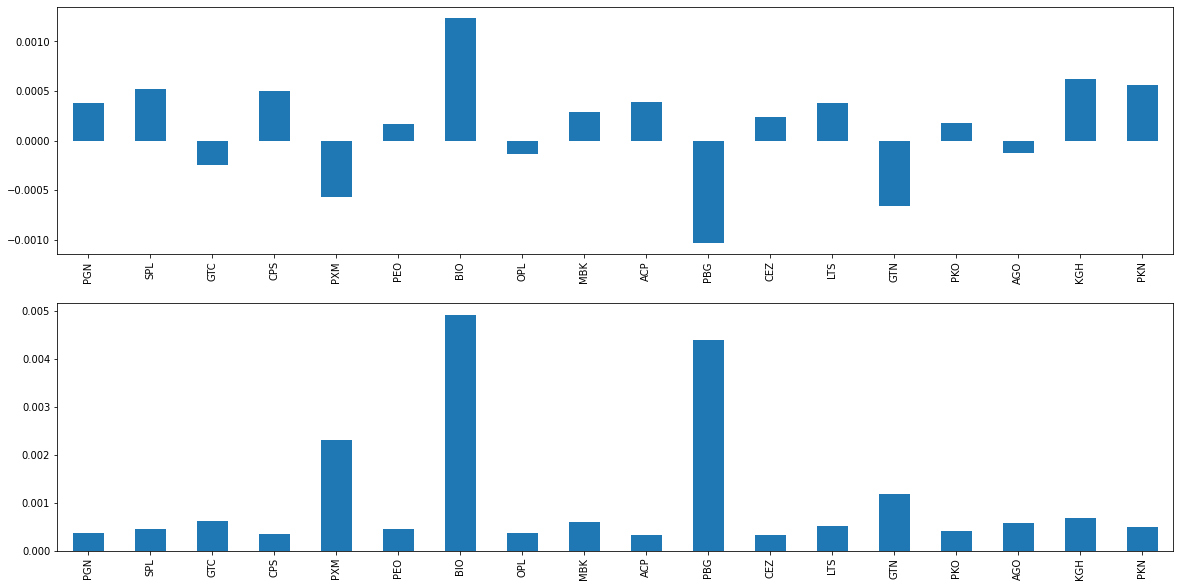

In [8]:
fig, axs = plt.subplots(2, figsize=(20, 10))
mean_var_df["mean"].plot(kind="bar", ax=axs[0])
mean_var_df["var"].plot(kind="bar", ax=axs[1])
plt.show()

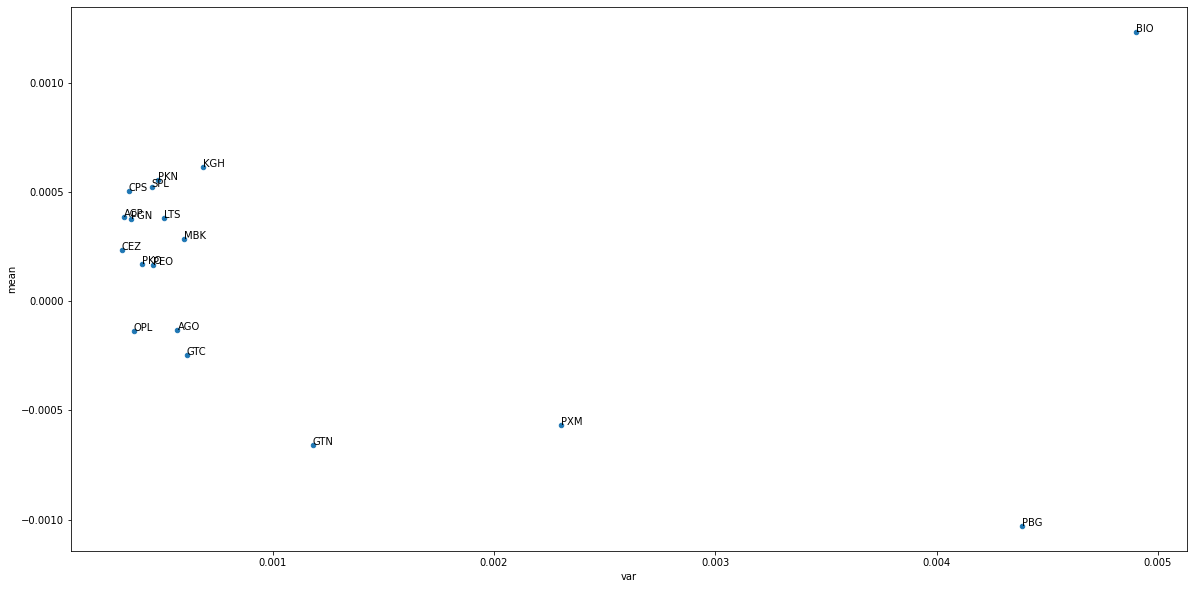

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_var_df.plot("var", "mean", kind="scatter", ax=ax)

for _, row in mean_var_df.iterrows():
    ax.annotate(row.name, (row["var"], row["mean"]))

plt.show()

## Correlation matrix of daily returns

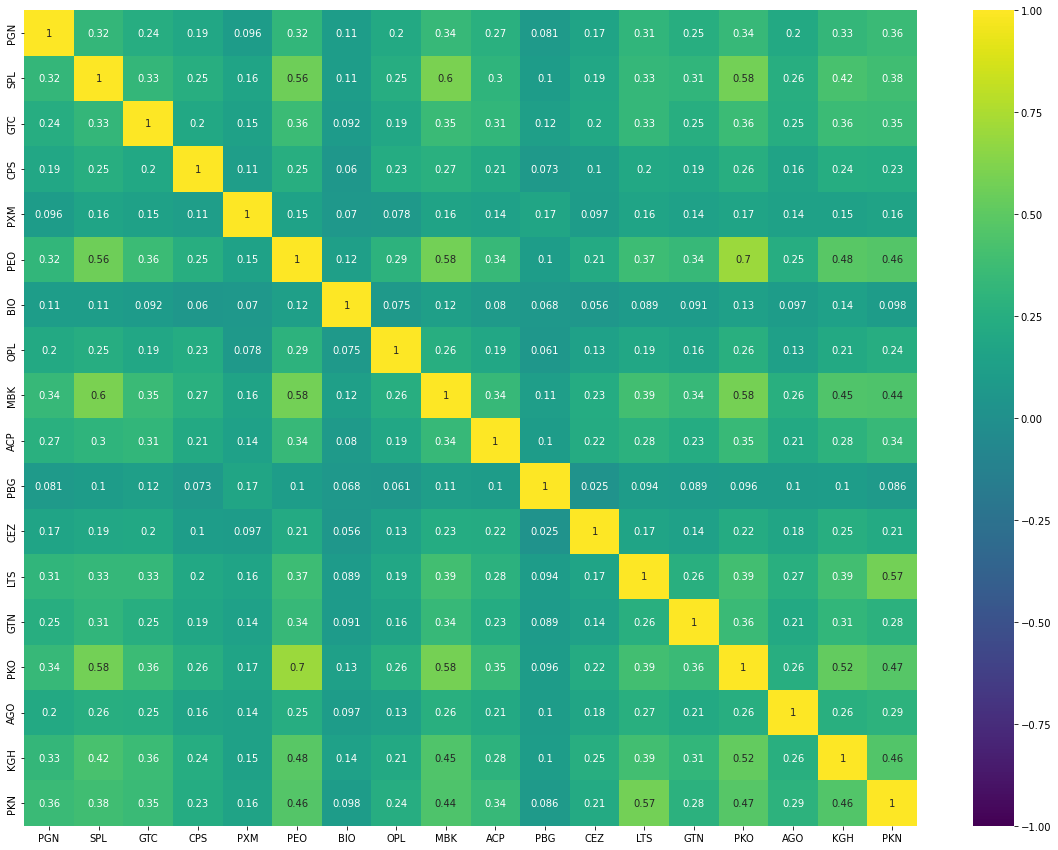

In [10]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df.corr(), ax=ax, annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.show()

## Modern portfolio theory

In [11]:
from qpsolvers import solve_qp

In [12]:
SIGMA = df.cov().to_numpy()
R = df.mean().to_numpy()

In [13]:
def get_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1))

def get_nonnegative_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1), np.zeros_like(R))

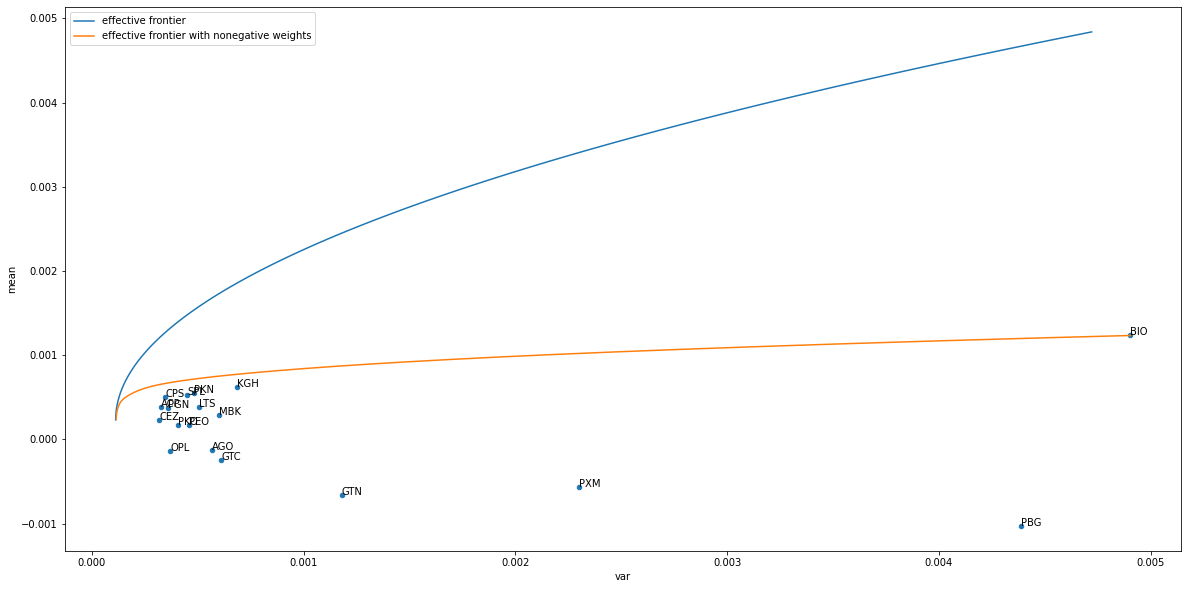

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_var_df.plot("var", "mean", kind="scatter", ax=ax)

for _, row in mean_var_df.iterrows():
    ax.annotate(row.name, (row["var"], row["mean"]))

arr = []
for q in np.linspace(0, 2, 100):
    w = get_weights(q)
    vol, ret = w.T @ SIGMA @ w, np.dot(R, w)
    arr.append([vol, ret])

nonneg_arr = []
for q in np.linspace(0, 30, 10000):
    w = get_nonnegative_weights(q)
    vol, ret = w.T @ SIGMA @ w, np.dot(R, w)
    nonneg_arr.append([vol, ret])

arr = np.array(arr)
nonneg_arr = np.array(nonneg_arr)
ax.plot(arr[:, 0], arr[:, 1], label="effective frontier")
ax.plot(nonneg_arr[:, 0], nonneg_arr[:, 1], label="effective frontier with nonegative weights")
ax.legend()
plt.show()

# Experiments with NSGA2

In [15]:
from nsga2.objectives import portfolios_neg_returns, portfolios_vars, portfolios_empirical_VaR, portfolios_semivariances
from nsga2.model import NSGA2
from nsga2.mutations import PolynomialMutation
import matplotlib as mpl

In [16]:
def objective(weights: np.ndarray) -> np.ndarray:
    return np.stack(
        [
            np.maximum(-0.01, portfolios_neg_returns(weights, R=R)),
            portfolios_vars(weights, SIGMA=SIGMA),
            portfolios_semivariances(weights, returns=np.asarray(df)),
            portfolios_empirical_VaR(weights, returns=np.asarray(df), alpha=0.95),
            portfolios_empirical_VaR(weights, returns=np.asarray(df), alpha=0.99),
        ], axis=-1,
    )

In [17]:
temp_df = df.agg(["mean"]).T
temp_df["variance"] = portfolios_vars(np.eye(len(df.columns)), SIGMA)
temp_df["semivariance"] = portfolios_semivariances(np.eye(len(df.columns)), np.asarray(df))
temp_df["VaR95"] = portfolios_empirical_VaR(np.eye(len(df.columns)), np.asarray(df), 0.95)
temp_df["VaR99"] = portfolios_empirical_VaR(np.eye(len(df.columns)), np.asarray(df), 0.99)
temp_df.head()

,mean,variance,semivariance,VaR95,VaR99
PGN,0.000377,0.000360,0.000321,0.029035,0.045783
SPL,0.000524,0.000452,0.000389,0.033472,0.055608
GTC,-0.000247,0.000611,0.000601,0.038308,0.067992
CPS,0.000504,0.000348,0.000321,0.028854,0.043379
PXM,-0.000566,0.002303,0.002226,0.075167,0.111111


In [18]:
weights_arr = []
for q in tqdm(np.linspace(0, 2, 10000)):
    weights_arr.append(get_weights(q))
weights_arr = np.asarray(weights_arr)

100%|██████████| 10000/10000 [00:00<00:00, 27849.11it/s]


In [19]:
def plot(history, start=2, end=None):
    fig, axs = plt.subplots(2, 2, figsize=(40, 20))
    axs = axs.flatten()
    temp_df.plot("variance", "mean", kind="scatter", ax=axs[0], label="stocks", c="orange", s=50, marker="o")
    temp_df.plot("semivariance", "mean", kind="scatter", ax=axs[1], label="stocks", c="orange", s=50, marker="o")
    temp_df.plot("VaR95", "mean", kind="scatter", ax=axs[2], label="stocks", c="orange", s=50, marker="o")
    temp_df.plot("VaR99", "mean", kind="scatter", ax=axs[3], label="stocks", c="orange", s=50, marker="o")

    end = np.log2(len(history)).astype(int) if end is None else end
    bounds = np.exp2(np.arange(start, end + 2)).astype(int)
    cmap = mpl.cm.get_cmap("viridis")
    norm = mpl.colors.BoundaryNorm(bounds / 1.5, cmap.N)
    idxs = bounds[:-1] - 1

    for obj, ax in zip(range(1, history.shape[-1]), axs):
        c = ax.scatter(history[idxs, :, obj], -history[idxs, :, 0], c=np.broadcast_to(idxs[..., None], (idxs.shape[0], history.shape[1])), cmap=cmap, norm=norm, alpha=0.6)
        fig.colorbar(c, ax=ax, label="iteracja", ticks=idxs+1)

    axs[0].scatter(portfolios_vars(weights_arr, SIGMA), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
    axs[1].scatter(portfolios_semivariances(weights_arr, np.asarray(df)), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
    axs[2].scatter(portfolios_empirical_VaR(weights_arr, np.asarray(df), 0.95), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
    axs[3].scatter(portfolios_empirical_VaR(weights_arr, np.asarray(df), 0.99), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)

    for ax in axs:
        ax.legend()
        ax.set_xscale("log")
    plt.show()

In [20]:
model = NSGA2(len(R), n_iterations=1024, population_size=512, mutation=PolynomialMutation(-1, 1))

In [21]:
history = model.simulate(objective)

100%|██████████| 1024/1024 [02:56<00:00,  5.82it/s]


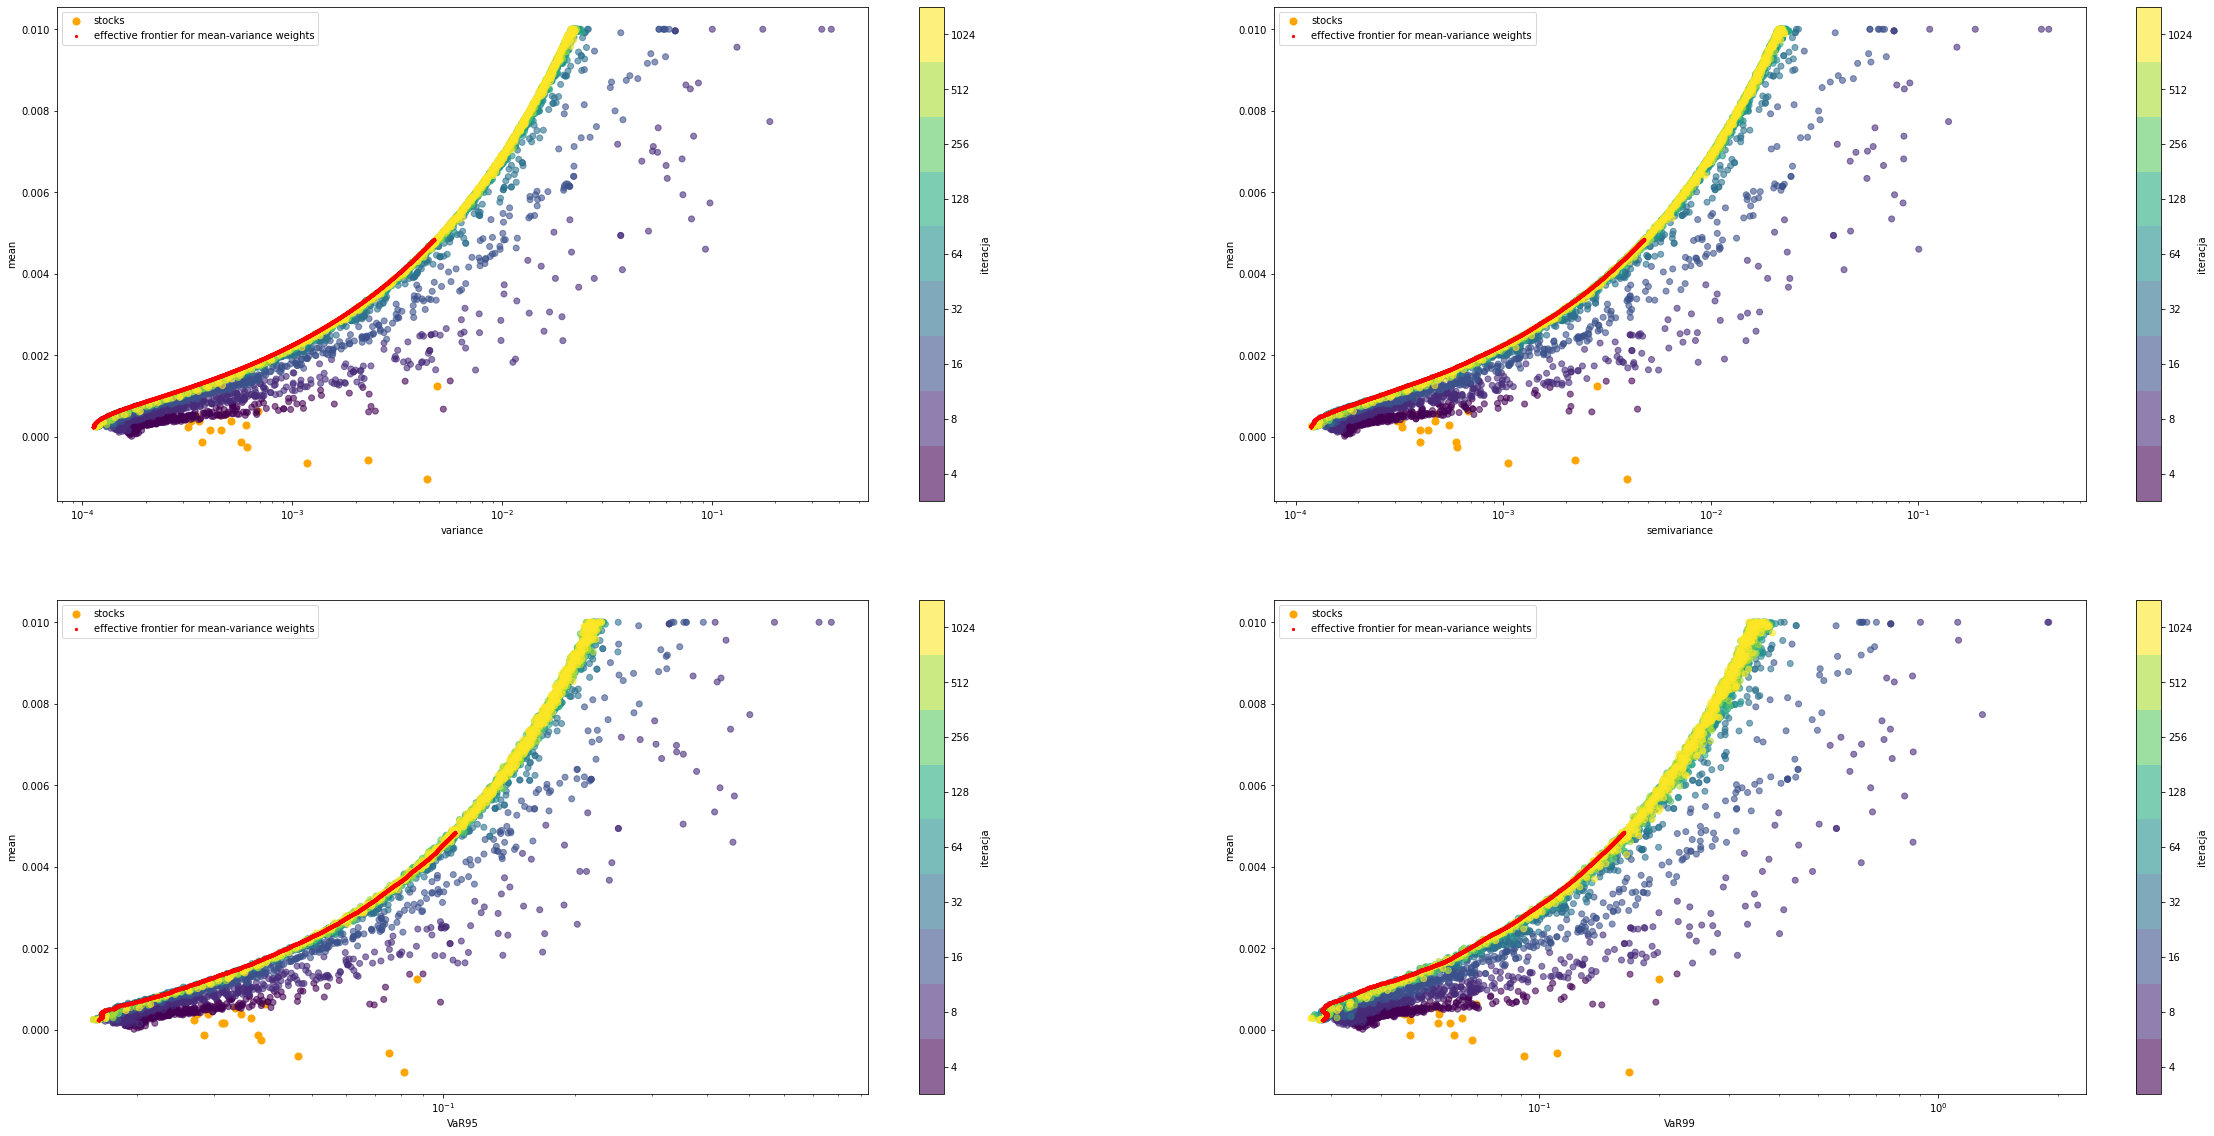

In [22]:
plot(history)